In [447]:
# Imports
import pickle
import torch
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import numpy as np

from torch import tensor, optim
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import BertTokenizer
from sklearn.feature_extraction.text import CountVectorizer

In [685]:
# Parameters and constants
MAX_LEN = 10000
learning_rate = 0.00001
epochs = 15
batch_size = 64
hidden_size = 64
train_factor = 0.6
test_factor = 0.2
valid_factor = 0.2

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Selected device: {device}")

Selected device: cuda


In [568]:
# Uploading our data from csv
df = pd.read_csv("./data/data.csv")
df["text"] = df["text"].fillna("")
df.head()

,Unnamed: 0,text,label
0,0,"Buck up, your troubles caused by small dimensi...",1
1,1,\nUpgrade your sex and pleasures with these te...,1
2,2,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1
3,3,Would anyone object to removing .so from this ...,0
4,4,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1


In [585]:
# Function to assess accuracy of the model
def accuracy(predictions: tensor, actuals: tensor) -> float:
    _, preds =torch.max(predictions, 1)
    preds
    accuracy = torch.sum(preds == actuals.view(-1))/x_batch.shape[0]
    return accuracy.item()

In [586]:
# Dataset
class EmailDataset(Dataset):
    def __init__(self, email_df, vectorizer):
        self.emails = email_df["text"]
        self.labels = tensor(email_df["label"], dtype=torch.long)
        self.vectorizer = vectorizer
        
        csr_matrix = self.vectorizer.transform(self.emails)
        coo_matrix = csr_matrix.tocoo()
        indices = tensor([coo_matrix.row, coo_matrix.col])
        values = tensor(coo_matrix.data, dtype=torch.float32)
        self.vectorized_emails = torch.sparse_coo_tensor(indices, values, torch.Size(coo_matrix.shape)).to_dense()
        
    def __getitem__(self, index):
        email_vector = self.vectorized_emails[index]
        label = self.labels[index]
        return email_vector.to(device), label.to(device)
    
    def __len__(self):
        return len(self.emails)

In [587]:
# Vectorizer to convert texts of emails to vectors
vectorizer = CountVectorizer(max_features=MAX_LEN)
vectorizer.fit(df["text"])

CountVectorizer(max_features=10000)

In [588]:
vectorizer.vocabulary_["cum"]

np.int64(2341)

In [589]:
ds = EmailDataset(df, vectorizer)

In [590]:
train_ds, valid_ds, test_ds = random_split(ds, [train_factor, valid_factor, test_factor])

In [669]:
# Dataloaders
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [686]:
# Model
class PhishingDetectorModel(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.layers = nn.ModuleList([
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 10),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(10, output_size),
        ])
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [687]:
model = PhishingDetectorModel(
    input_size=MAX_LEN,
    hidden_size=hidden_size, 
    output_size=2
).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

In [688]:
# Training loop
losses = []
accuracies = []

for epoch in range(epochs):
    model.train()
    for x_batch, y_batch in train_dl:
        optimizer.zero_grad()
        predictions = model(x_batch)
        loss = loss_function(predictions, y_batch.view(-1))
        
        loss.backward()
        optimizer.step()
        
    model.eval()
    total_loss, total_acc, count = 0., 0., 0.
    for x_batch, y_batch in valid_dl:
        predictions = model(x_batch)
        loss = loss_function(predictions, y_batch.view(-1))
        count += len(x_batch)
        total_loss += loss.item()
        acc = accuracy(predictions, y_batch.view(-1))
        total_acc += acc * len(x_batch)
    losses.append(total_loss / count)
    accuracies.append(total_acc / count)
    
    print(f"Epoch: {epoch}, Loss: {total_loss / count}, Accuracy: {total_acc / count}")
        

Epoch: 0, Loss: 0.008161994823499328, Accuracy: 0.6609569215498485
Epoch: 1, Loss: 0.006274160328176061, Accuracy: 0.8405584879898241
Epoch: 2, Loss: 0.005161087691692564, Accuracy: 0.9106078665584919
Epoch: 3, Loss: 0.004427517197230758, Accuracy: 0.9342073898004467
Epoch: 4, Loss: 0.0038689879355795153, Accuracy: 0.943095521877759
Epoch: 5, Loss: 0.003479933374108315, Accuracy: 0.9436063340691434
Epoch: 6, Loss: 0.0031547313765713856, Accuracy: 0.9439809296761585
Epoch: 7, Loss: 0.0029051665566187995, Accuracy: 0.9442874169909892
Epoch: 8, Loss: 0.002719304217008194, Accuracy: 0.945581474542496
Epoch: 9, Loss: 0.002570394277014441, Accuracy: 0.946262557490729
Epoch: 10, Loss: 0.0024472452079784966, Accuracy: 0.9466030989516518
Epoch: 11, Loss: 0.0023397024703780897, Accuracy: 0.9481014813797124
Epoch: 12, Loss: 0.002244532456922507, Accuracy: 0.949361484785127
Epoch: 13, Loss: 0.0021714651723411813, Accuracy: 0.9513366252584797
Epoch: 14, Loss: 0.002102605412923029, Accuracy: 0.95242

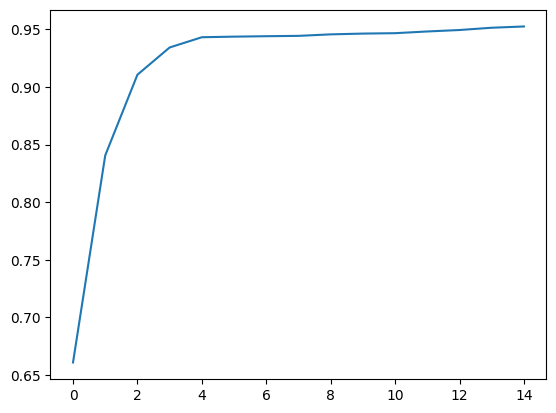

In [689]:
plt.plot(accuracies)

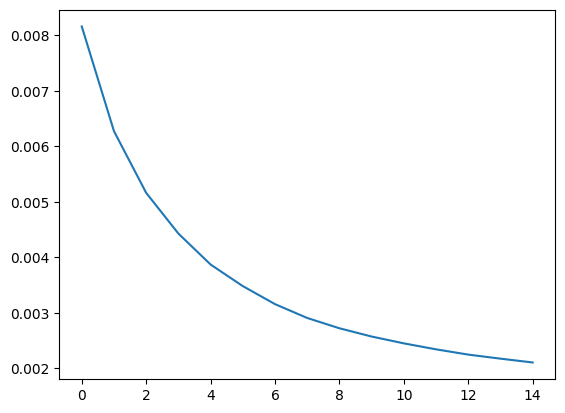

In [690]:
plt.plot(losses)    

In [472]:
x_batch, y_batch = next(iter(test_dl))
x_batch[1], y_batch[1]

(tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 tensor(1, device='cuda:0'))

In [479]:
x_batch.shape, y_batch.shape

(torch.Size([128, 10000]), torch.Size([128]))

In [485]:
predictions = model(x_batch)
probabilities = torch.sigmoid(predictions)
probabilities = torch.softmax(predictions, dim=1)
acc = accuracy(probabilities[:, 1], y_batch.view(-1))

In [491]:
_, preds =torch.max(predictions, 1)
preds

tensor([1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
        1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')

In [498]:
torch.sum(preds == y_batch.view(-1))/x_batch.shape[0]

tensor(0.9531, device='cuda:0')

In [676]:
accuracy(predictions, y_batch)

0.9056603908538818

In [692]:
def predict_email(email, model, vectorizer, device, top_n=5):
    model.eval()
    
    email_csrmatrix = vectorizer.transform([email])
    email_coomatrix = email_csrmatrix.tocoo()
    indices = tensor([email_coomatrix.row, email_coomatrix.col]).to(device)
    values = tensor(email_coomatrix.data, dtype=torch.float32).to(device)
    email_tensor = torch.sparse_coo_tensor(indices, values, torch.Size(email_coomatrix.shape)).to_dense().to(device)
    
    with torch.no_grad():
        outputs = model(email_tensor)
        _, prediction = torch.max(outputs, 1)
        
        first_layer_weights = model.layers[0].weight.data.cpu().numpy()
        suspicious_weights = first_layer_weights[1]
        
        word_importance = email_tensor[0].cpu() * suspicious_weights
        important_words_indices = np.argsort(word_importance)[-top_n:]
        
        important_words = [vectorizer.get_feature_names_out()[i] for i in important_words_indices]
        important_scores = [word_importance[i] for i in important_words_indices]
        
        important_scores = tensor(important_scores).softmax(dim=0)
        important_scores = [score * 100 for score in important_scores]
    
    return prediction.item(), torch.softmax(outputs, dim=1).cpu().numpy(), list(zip(important_words, important_scores))

In [694]:
sus_mail = """Dear [Your Name],

We hope you're doing well. Your monthly bank statement for September 2024 is now available. You can view and download your statement by logging into your account.

To access your statement:

Go to our official website: www.yourbank.com.
Log in with your credentials.
Navigate to the "Statements" section under your account dashboard.
If you have any questions or need assistance, please feel free to contact our customer support team.

Thank you for banking with us!

Best regards,
Customer Service Team
YourBank Inc.
Contact Us: 1-800-123-4567
www.yourbank.com"""

ok_mail = """Hey [Your Name],

I hope you're doing well! It's been a while since we last caught up, and I was thinking it would be great to hang out sometime soon. How about grabbing coffee this weekend?

Let me know if you're free, or if another time works better for you. I’d love to hear what you’ve been up to lately and share some updates on my end too!

Looking forward to seeing you soon.

Take care,
[Friend's Name]

P.S. If you're busy this weekend, no worries—we can plan for another time! :)"""
 
sus, confidency, words = predict_email(sus_mail, model, vectorizer, device, top_n=10)

print(f"Sus: {sus}, Confidence: {confidency.max() * 100:.2f}, Words: {words}")

Sus: 1, Confidence: 81.55, Words: [('dear', tensor(9.7662)), ('you', tensor(9.8051)), ('com', tensor(9.8112)), ('contact', tensor(9.8331)), ('regards', tensor(9.8605)), ('for', tensor(9.8875)), ('best', tensor(9.9215)), ('to', tensor(10.0664)), ('our', tensor(10.1524)), ('your', tensor(10.8962))]


C:\Users\sqdar\AppData\Local\Temp\ipykernel_12488\1932624220.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  word_importance = email_tensor[0].cpu() * suspicious_weights


In [677]:
losses, accuracies = [], []
total_loss, total_acc, count = 0., 0., 0.
 
for x_batch, y_batch in test_dl:
    predictions = model(x_batch)
    loss = loss_function(predictions, y_batch.view(-1))
    count += len(x_batch)
    total_loss += loss.item()
    acc = accuracy(predictions, y_batch)
    total_acc += acc * len(x_batch)
losses.append(total_loss / count)
accuracies.append(total_acc / count)

print(f"Loss: {total_loss / count}, Accuracy: {total_acc / count}")

Loss: 0.002259331619720452, Accuracy: 0.947248331290015
